# Titanic Classification Exercise

## Setup and Load the data

In [49]:
# Setup

import os
import pandas as pd
import numpy as np

In [50]:
# Load the data

TITANIC_DATA_PATH = os.path.join("datasets", "titanic")

# This function returns a pandas DataFrame object containing all the data.
def load_titanic_data(filename, data_path=TITANIC_DATA_PATH):
    csv_path = os.path.join(data_path, filename)
    return pd.read_csv(csv_path)

training_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")


Note that the test data does not contain the labels, our goal is to train the best model possible on the training data, then make predictions on the test data, and upload the results to Kaggle.com to see our final score.

## Prepare the Data for Machine Learning Algorithms

We need to take care of the missing attributes and categorical attributes.

In [51]:
# Create the Labels
y_train_labels = training_data["Survived"].copy()
y_train_labels.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [52]:
# We will reuse the DataframeSelector we built in the previous chapter to select specific attributes from the DataFrame:

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

class NumericalAttributesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        return np.c_[X]
            

class CategoricalAttributesTransformer(BaseEstimator, TransformerMixin):        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        X["Sex"].replace('male', 0, inplace=True)
        X["Sex"].replace('female', 1, inplace=True)  
        return np.c_[X]

#### Transformation Pipelines

In [54]:
# Pipeline Setup
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy="median")

In [55]:
# Here is a small pipeline for the numerical attributes

numerical_attributes_pipeline = Pipeline([
    ("select_numerical_attributes", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ('imputer', SimpleImputer(strategy='median')), # Fill blank values with most frequent
    ('numerical_attributes_transformer', NumericalAttributesTransformer()),
    ('std_scaler', StandardScaler()), # Feature Scaling
])

In [56]:
# Here is a small pipeline for the categorical attributes

categorical_attributes_pipeline = Pipeline([
    ("select_categorical_attributes", DataFrameSelector(["Sex"])),
    ('categorical_attributes_transformer', CategoricalAttributesTransformer()),
])

In [57]:
# Data transformation pipeline to apply all the transformations to the titanic data

from sklearn.pipeline import FeatureUnion

data_preprocess_pipeline = FeatureUnion(transformer_list=[
        ('numerical_attributes_pipeline', numerical_attributes_pipeline),
        ('categorical_attributes_pipeline', categorical_attributes_pipeline),
])

X_train = data_preprocess_pipeline.fit_transform(training_data)

## Select and Train a Model

### RandomForestClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

Next we’ll try a RandomForestClassifier and compare its ROC curve and ROC AUC Score

Note that the RandomForestClassifier doesn't have a decision_function() instead we need to use its predict_proba() function.

Generally SKLearn classifiers have one or the other or both.

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

random_forest_classifier = RandomForestClassifier(random_state=42)
y_probabilities_rfc = cross_val_predict(random_forest_classifier, X_train, y_train_labels, cv=3, method="predict_proba")

In [100]:
# The roc_curve() function expects labels and scores but instead of scores we can give it probabilities
y_scores_rfc = y_probabilities_rfc[:,1] # score = proba of positive class
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_train_labels, y_scores_rfc)

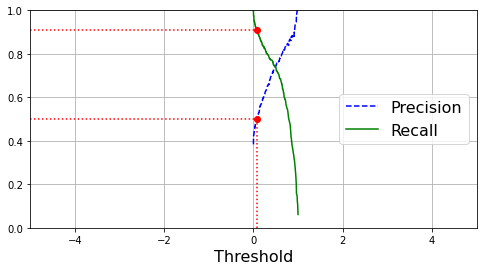

In [102]:
# Let's do the following cross-validation to decide on which threshold value to use
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_labels, y_scores_rfc)

%matplotlib inline
# ^ Jupyter notebook command for inline matplotlib
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-5, 5, 0, 1])             

recall_50_precision = recalls[np.argmax(precisions >= 0.50)]
threshold_50_precision = thresholds[np.argmax(precisions >= 0.50)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_50_precision, threshold_50_precision], [0., 0.5], "r:")                 
plt.plot([-5, threshold_50_precision], [0.5, 0.5], "r:")                                
plt.plot([-5, threshold_50_precision], [recall_50_precision, recall_50_precision], "r:")
plt.plot([threshold_50_precision], [0.5], "ro")                                             
plt.plot([threshold_50_precision], [recall_50_precision], "ro")                             
plt.show()

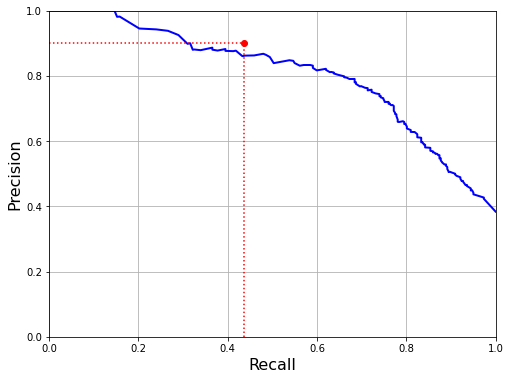

In [103]:
# We can also plot precision vs. recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

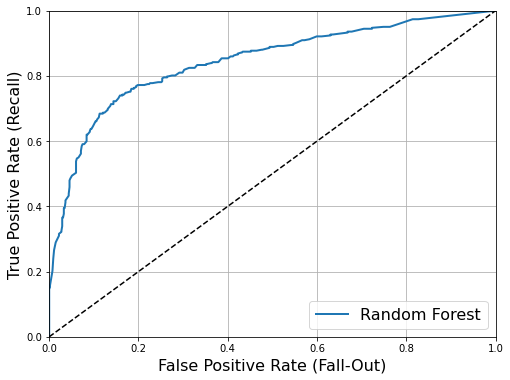

In [106]:
# Next let's plot the ROC Curve
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0,1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

# Now we can plot the ROC Curve for the RF Classifier and compare it to the SGD Classifier
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_rfc, tpr_rfc, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [108]:
# Next let's computer the ROC AUC (Area under the Curve)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_labels, y_scores_rfc)

0.8425659625688386

## Fine-Tune Your Model

### GridSearchCV

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


In [65]:
from sklearn.model_selection import GridSearchCV

parameter_grid = {
    'n_estimators': [10, 30, 100, 300],
    'max_depth': [1, 3, 10, 30, 100],
    'min_samples_split': [1, 3, 10, 30],
    'min_samples_leaf': [1, 3, 10, 30],
    'max_features': [1, 3, 10, 30, 100],
    'bootstrap': [True, False],
    'random_state': [42]
}

random_forest_classifier = RandomForestClassifier()

grid_search = GridSearchCV(
    estimator = random_forest_classifier, 
    param_grid = parameter_grid, 
    cv = 3, 
    n_jobs = -1, 
    verbose = 2
)

grid_search.fit(X_train, y_train_labels)

Fitting 3 folds for each of 3200 candidates, totalling 9600 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 2120 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 3674 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 5684 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 8112 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 9569 out of 9600 | elapsed:  1.1min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 9600 out of 9600 | elapsed:  1.1min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [1, 3, 10, 30, 100],
                         'max_features': [1, 3, 10, 30, 100],
                         'min_samples_leaf': [1, 3, 10, 30],
                         'min_samples_split': [1, 3, 10, 30],
                         'n_estimators': [10, 30, 100, 300],
                         'random_state': [42]},
             verbose=2)

In [66]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 30,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 30,
 'n_estimators': 300,
 'random_state': 42}

In [67]:
grid_search.best_score_

0.8215488215488215

In [68]:
# This doesn't look all that promising, maybe we should zero in on best parameters and create a distribution closer to those.

In [69]:
parameter_grid = {
    'n_estimators': [80, 90, 100, 110, 120],
    'max_depth': [24, 26, 28, 30, 32, 34, 36],
    'min_samples_split': [6, 8, 10, 12, 14],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [1, 2, 3, 4, 5],
    'bootstrap': [True, False],
    'random_state': [42]
}

random_forest_classifier = RandomForestClassifier()

grid_search = GridSearchCV(
    estimator = random_forest_classifier, 
    param_grid = parameter_grid, 
    cv = 3, 
    n_jobs = -1, 
    verbose = 2
)

grid_search.fit(X_train, y_train_labels)

Fitting 3 folds for each of 7000 candidates, totalling 21000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1930 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 2820 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 3874 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 5088 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 6466 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 8004 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 9706 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 11568 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 13594 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 15780 tasks

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [24, 26, 28, 30, 32, 34, 36],
                         'max_features': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [6, 8, 10, 12, 14],
                         'n_estimators': [80, 90, 100, 110, 120],
                         'random_state': [42]},
             verbose=2)

In [70]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 24,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'n_estimators': 100,
 'random_state': 42}

In [71]:
grid_search.best_score_

0.8249158249158248

In [72]:
# This isn't an improvement (0.2% improvement) over the initial best parameters we found.

### Analyze the Best Models and Their Error

### Feature Importance

In [112]:
# Let's look at the relative importance of each attribute for making accurate predictions
feature_importances = grid_search.best_estimator_.feature_importances_
numerical_attributes = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
extra_attributes = ["Fmembers"]
category_attributes = ["Sex"]
attributes = numerical_attributes + extra_attributes + category_attributes
print(sorted(zip(feature_importances, attributes), reverse=True))

[(0.3774793531276585, 'Fare'), (0.30441130882676903, 'Parch'), (0.19713093222101224, 'Pclass'), (0.0736029861156206, 'Age'), (0.04737541970893965, 'SibSp')]


In [113]:
# Let's create a pipeline to select the most important 'k' features

def indices_of_top_k(array, k):
    return np.sort(np.argpartition(np.array(array), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]
    
# Note that this feature selector assumes you have already computed the feature importances

In [115]:
k = 5
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([0, 1, 2, 3, 4], dtype=int64)

In [116]:
np.array(attributes)[top_k_feature_indices]

array(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='<U8')

In [117]:
# Let's double check that these are indeed the top k features:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.3774793531276585, 'Fare'),
 (0.30441130882676903, 'Parch'),
 (0.19713093222101224, 'Pclass'),
 (0.0736029861156206, 'Age'),
 (0.04737541970893965, 'SibSp')]

### Feature Importance Pipeline

In [119]:
# Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', data_preprocess_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [120]:
# Let's test that this is working.
# To check, let's look at the features of the first 3 instances and compare them to the top k features

training_data_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(training_data)

In [121]:
training_data_prepared_top_k_features[0:3]

array([[-0.56573646,  0.43279337, -0.47367361, -0.50244517,  0.        ],
       [ 0.66386103,  0.43279337, -0.47367361,  0.78684529,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, -0.48885426,  1.        ]])

In [123]:
X_train[0:3, top_k_feature_indices]

array([[-0.56573646,  0.43279337, -0.47367361, -0.50244517,  0.        ],
       [ 0.66386103,  0.43279337, -0.47367361,  0.78684529,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, -0.48885426,  1.        ]])

In [124]:
# They match, looks good.

## Full Pipeline

A single pipeline that does the full data preparation plus the final prediction

In [128]:
prepare_and_select_and_predict_pipeline = Pipeline([
    ('preparation', data_preprocess_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('random_forest', RandomForestClassifier(**grid_search.best_params_)) # These params are from above
])

prepare_and_select_and_predict_pipeline.fit(training_data, y_train_labels)

Pipeline(steps=[('preparation',
                 FeatureUnion(transformer_list=[('numerical_attributes_pipeline',
                                                 Pipeline(steps=[('select_numerical_attributes',
                                                                  DataFrameSelector(attribute_names=['Age',
                                                                                                     'SibSp',
                                                                                                     'Parch',
                                                                                                     'Fare'])),
                                                                 ('imputer',
                                                                  SimpleImputer(strategy='median')),
                                                                 ('numerical_attributes_transformer',
                                                                  Num

In [130]:
# Let's try the full pipeline on a few instances:

some_data = training_data.iloc[:4]
some_labels = y_train_labels.iloc[:4]

print("Predictions:\t", prepare_and_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [0 1 1 1]
Labels:		 [0, 1, 1, 1]


In [85]:
# We can see that the full pipeline is working.